#### Author：马肖
#### E-Mail：maxiaoscut@aliyun.com
#### GitHub：https://github.com/Albertsr

### XGBoost的损失函数必须为二阶可导的凸函数
- 因为XGB需要计算二阶偏导数的累计平方和

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, mean_squared_error, accuracy_score, recall_score
from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font', family='SimHei', size=18)
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


X, y = make_classification(n_samples=1000, n_features=10, n_informative=8, n_classes=2, random_state=2018)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y, test_size=0.25, random_state=2018)

X, y = make_regression(n_samples=1000, n_features=10, n_informative=8, n_targets=1, random_state=2018)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.25, random_state=2018)

### 1.以ln(cosh(x))为损失函数
https://baike.baidu.com/item/cosh/3535060

In [2]:
# 定义函数
def log_cosh_obj(y_true, y_pred):
    delta = y_pred - y_true 
    grad = np.tanh(delta)
    hess = (1.0 - grad*grad)
    return grad, hess

# 回归问题
model = XGBRegressor(objective=log_cosh_obj)
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred)
print('MSE:{:.6f}'.format(mse))

# 分类问题
model = XGBClassifier(objective=log_cosh_obj)
model.fit(X_train_clf, y_train_clf)
y_pred, y_prob = model.predict(X_test_clf), model.predict_proba(X_test_clf)[:, -1]
auc = roc_auc_score(y_test_clf, y_prob)
f1 = f1_score(y_test_clf, y_pred)
acc = accuracy_score(y_test_clf, y_pred)
print('AUC:{:.6f}, F1:{:.6f}, Acc:{:.6f}'.format(auc, f1, acc))

MSE:1133.472053
AUC:0.922540, F1:0.825397, Acc:0.824000


### 2. Pseudo-Huber loss function，可以近似替代MAE

In [3]:
# 定义损失函数
def huber_approx_obj(y_true, y_pred, h=1):
    # h为Pseudo-Huber loss function中的参数，用于调节坡度，其值越大，图像越陡峭
    d = y_pred - y_true 
    scale = 1 + np.square(d / h)
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

# 回归问题
model = XGBRegressor(objective=huber_approx_obj)
# model = XGBRegressor(objective='reg:linear')
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred)
print('MSE:{:.6f}'.format(mse))

# 分类问题
model = XGBClassifier(objective=huber_approx_obj)
model.fit(X_train_clf, y_train_clf)
y_pred, y_prob = model.predict(X_test_clf), model.predict_proba(X_test_clf)[:, -1]
auc = roc_auc_score(y_test_clf, y_prob)
f1 = f1_score(y_test_clf, y_pred)
acc = accuracy_score(y_test_clf, y_pred)
print('AUC:{:.6f}, F1:{:.6f}, Acc:{:.6f}'.format(auc, f1, acc))

MSE:1111.974434
AUC:0.928238, F1:0.830040, Acc:0.828000


In [4]:
def huber_approx_obj(y_true, y_pred, h=1):
    # h为Pseudo-Huber loss function中的参数，用于调节坡度，其值越大，图像越陡峭
    d = y_pred - y_true 
    scale = 1 + np.square(d / h)
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

In [5]:
def f1(x, h=1):
    a = np.sqrt(1 + np.square(x/h))
    return h**2 * (a-1) 

def f2(x):
    return np.log(np.cosh(x))

def f3(x):
    return np.log(np.exp(-x)+np.exp(x))

x = np.arange(-7, 8)
huber_1 = [f1(i) for i in x]
mae = [abs(i) for i in x]
incosh = [f2(i) for i in x]
logexp = [f3(i) for i in x]

Text(0.5, 1.0, '损失函数趋势图          Auther：马肖')

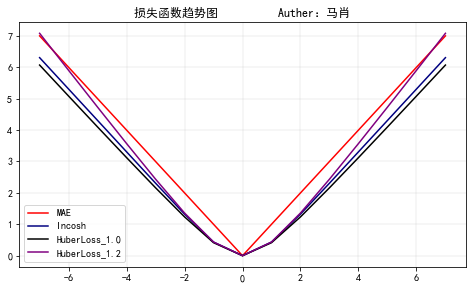

In [6]:
plt.figure(figsize=(8, 4.5))
plt.plot(x, mae, color='red', label='MAE')
plt.plot(x, incosh, color='navy', label='Incosh')


plt.plot(x, huber_1, color='k', label='HuberLoss_1.0')
huber_ = [f1(i, h=1.2) for i in x]
plt.plot(x, huber_, color='purple', label='HuberLoss_1.2')
plt.grid(lw=0.2)
plt.legend()
plt.title('损失函数趋势图          Auther：马肖')